In [2]:
import pandas as pd
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers, Model

from sklearn.utils.class_weight import compute_class_weight

from matplotlib import pyplot as plt

from datetime import datetime

import pickle

from PIL import Image

from custom_class import *

print(f"pd.__version__: {pd.__version__}")
print(f"tf.__version__: {tf.__version__}")

2025-03-25 23:42:56.498203: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-25 23:42:56.553505: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-25 23:42:56.553553: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-25 23:42:56.558812: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-25 23:42:56.579673: I tensorflow/core/platform/cpu_feature_guar

pd.__version__: 2.2.3
tf.__version__: 2.15.1


In [3]:
dataset_dir = "../Dataset/machine-learning-in-science-ii-2025/test_data/test_data"

ds = tf.data.Dataset.list_files(
    os.path.join(dataset_dir, "*"), shuffle=False
)
image_count = len(ds)

for f in ds.take(5):
    print(f.numpy())

# Extract image IDs
def extract_image_id(file_path):
    file_path = file_path.numpy().decode("utf-8")  # Convert from bytes to string
    filename = os.path.basename(file_path)  # Extract "1.png", "10.png", etc.
    image_id = filename.split(".")[0]  # Extract "1", "10", "100"
    return image_id

image_id_list = []

for path in ds:
    image_id_list.append(extract_image_id(path))

image_id_list = np.array(image_id_list)

2025-03-25 23:42:59.161458: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-25 23:42:59.255936: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-25 23:42:59.255979: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-25 23:42:59.260516: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-25 23:42:59.260587: I external/local_xla/xla/stream_executor

b'../Dataset/machine-learning-in-science-ii-2025/test_data/test_data/1.png'
b'../Dataset/machine-learning-in-science-ii-2025/test_data/test_data/10.png'
b'../Dataset/machine-learning-in-science-ii-2025/test_data/test_data/100.png'
b'../Dataset/machine-learning-in-science-ii-2025/test_data/test_data/1000.png'
b'../Dataset/machine-learning-in-science-ii-2025/test_data/test_data/1001.png'


In [4]:
def decode_img(img):
    # Convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img

def process_path(file_path):
    # Load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img

In [5]:
ds = ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)

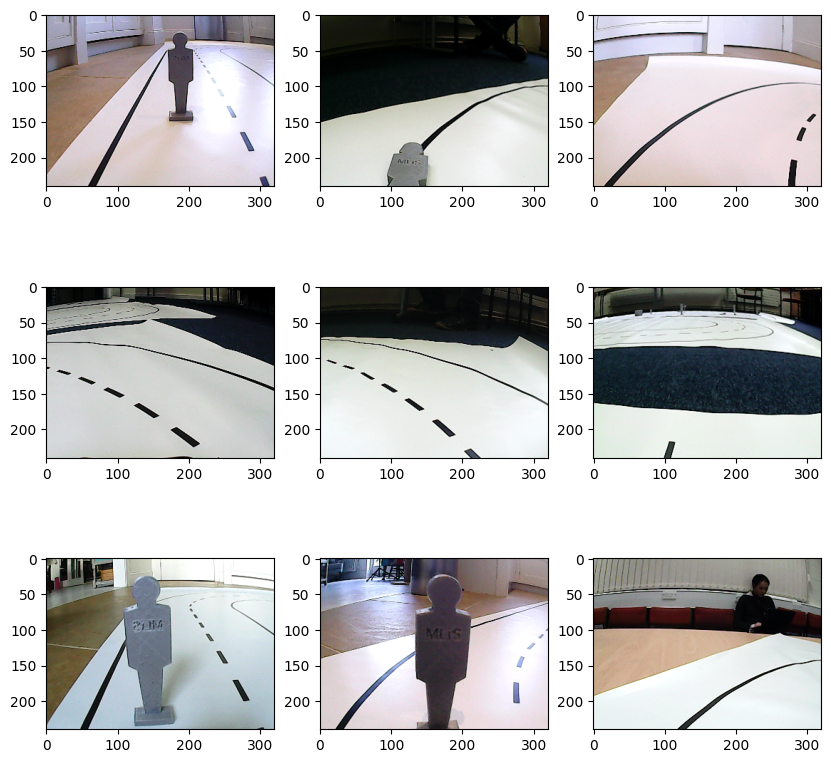

In [6]:
plt.figure(figsize=(10, 10))

i = 0

for image in ds.take(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("float32"))
    i += 1

In [7]:
def scale_ds(image):
    # Range of input image: [0, 1]
    return image * 2 - 1.0

def configure_for_performance(ds):
    ds = ds.batch(1, drop_remainder=False)
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds

ds = ds.map(scale_ds, num_parallel_calls=tf.data.AUTOTUNE)
ds = configure_for_performance(ds)

In [8]:
model_paths = [
    "/mnt/c/Users/psamt/OneDrive - The University of Nottingham/_Spring/PHYS4036_Machine Learning in Science Part II/Project/Models/kaggle_submission/angle_model_20250310_1824_good/angle_model_20250310_1824.keras",
    "/mnt/c/Users/psamt/OneDrive - The University of Nottingham/_Spring/PHYS4036_Machine Learning in Science Part II/Project/Models/kaggle_submission/angle_model_20250310_2058_good/angle_model_20250310_2058.keras",
]

preds = []

for model_path in model_paths:
    print(f"Loading model {model_path.split('/')[-1]}")
    model = keras.models.load_model(
        model_path,
    )
    preds.append(model.predict(ds))


Loading model angle_model_20250310_1824.keras


2025-03-25 23:46:24.202607: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2025-03-25 23:46:24.346116: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-03-25 23:46:24.894184: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1020/1020 [==============================] - 19s 16ms/step
Loading model angle_model_20250310_2058.keras


1020/1020 [==============================] - 15s 14ms/step


In [9]:
preds_concat = []

for pred in preds:
    for p in pred.values():
        preds_concat.append(p[:, 0])

preds_concat = np.array(preds_concat)

print(preds_concat)

preds_concat_fixed = np.where(np.abs(preds_concat - 0.5) < 0.1, preds_concat, (preds_concat - 0.5) * 1.1 + 0.5)
preds_concat_fixed = np.clip(preds_concat_fixed, 0, 1)

preds_concat_fixed_mean = preds_concat_fixed.mean(axis=0)

print(preds_concat_fixed_mean)

[[0.5488374  0.330405   0.6809686  ... 0.9121692  0.6735315  0.7874035 ]
 [0.56022185 0.3462194  0.64579326 ... 0.80811024 0.6526926  0.82264894]
 [0.5557598  0.25465044 0.67196405 ... 0.8824442  0.6833812  0.84013015]
 ...
 [0.55320895 0.38950294 0.6155178  ... 0.90955377 0.6660731  0.81252396]
 [0.55569845 0.38007012 0.6245639  ... 0.796637   0.65331095 0.8648025 ]
 [0.55334806 0.323234   0.63796264 ... 0.90254974 0.6454318  0.8052287 ]]
[0.54902256 0.32337573 0.6618954  ... 0.90141094 0.6864239  0.8622236 ]


In [26]:
std = (np.std(preds_concat, axis=0))
df = pd.DataFrame({
  'image_id': image_id_list.astype(int), 
  'angle': preds_concat_fixed_mean,
  'std': std
}).sort_values('image_id').reset_index(drop=True)

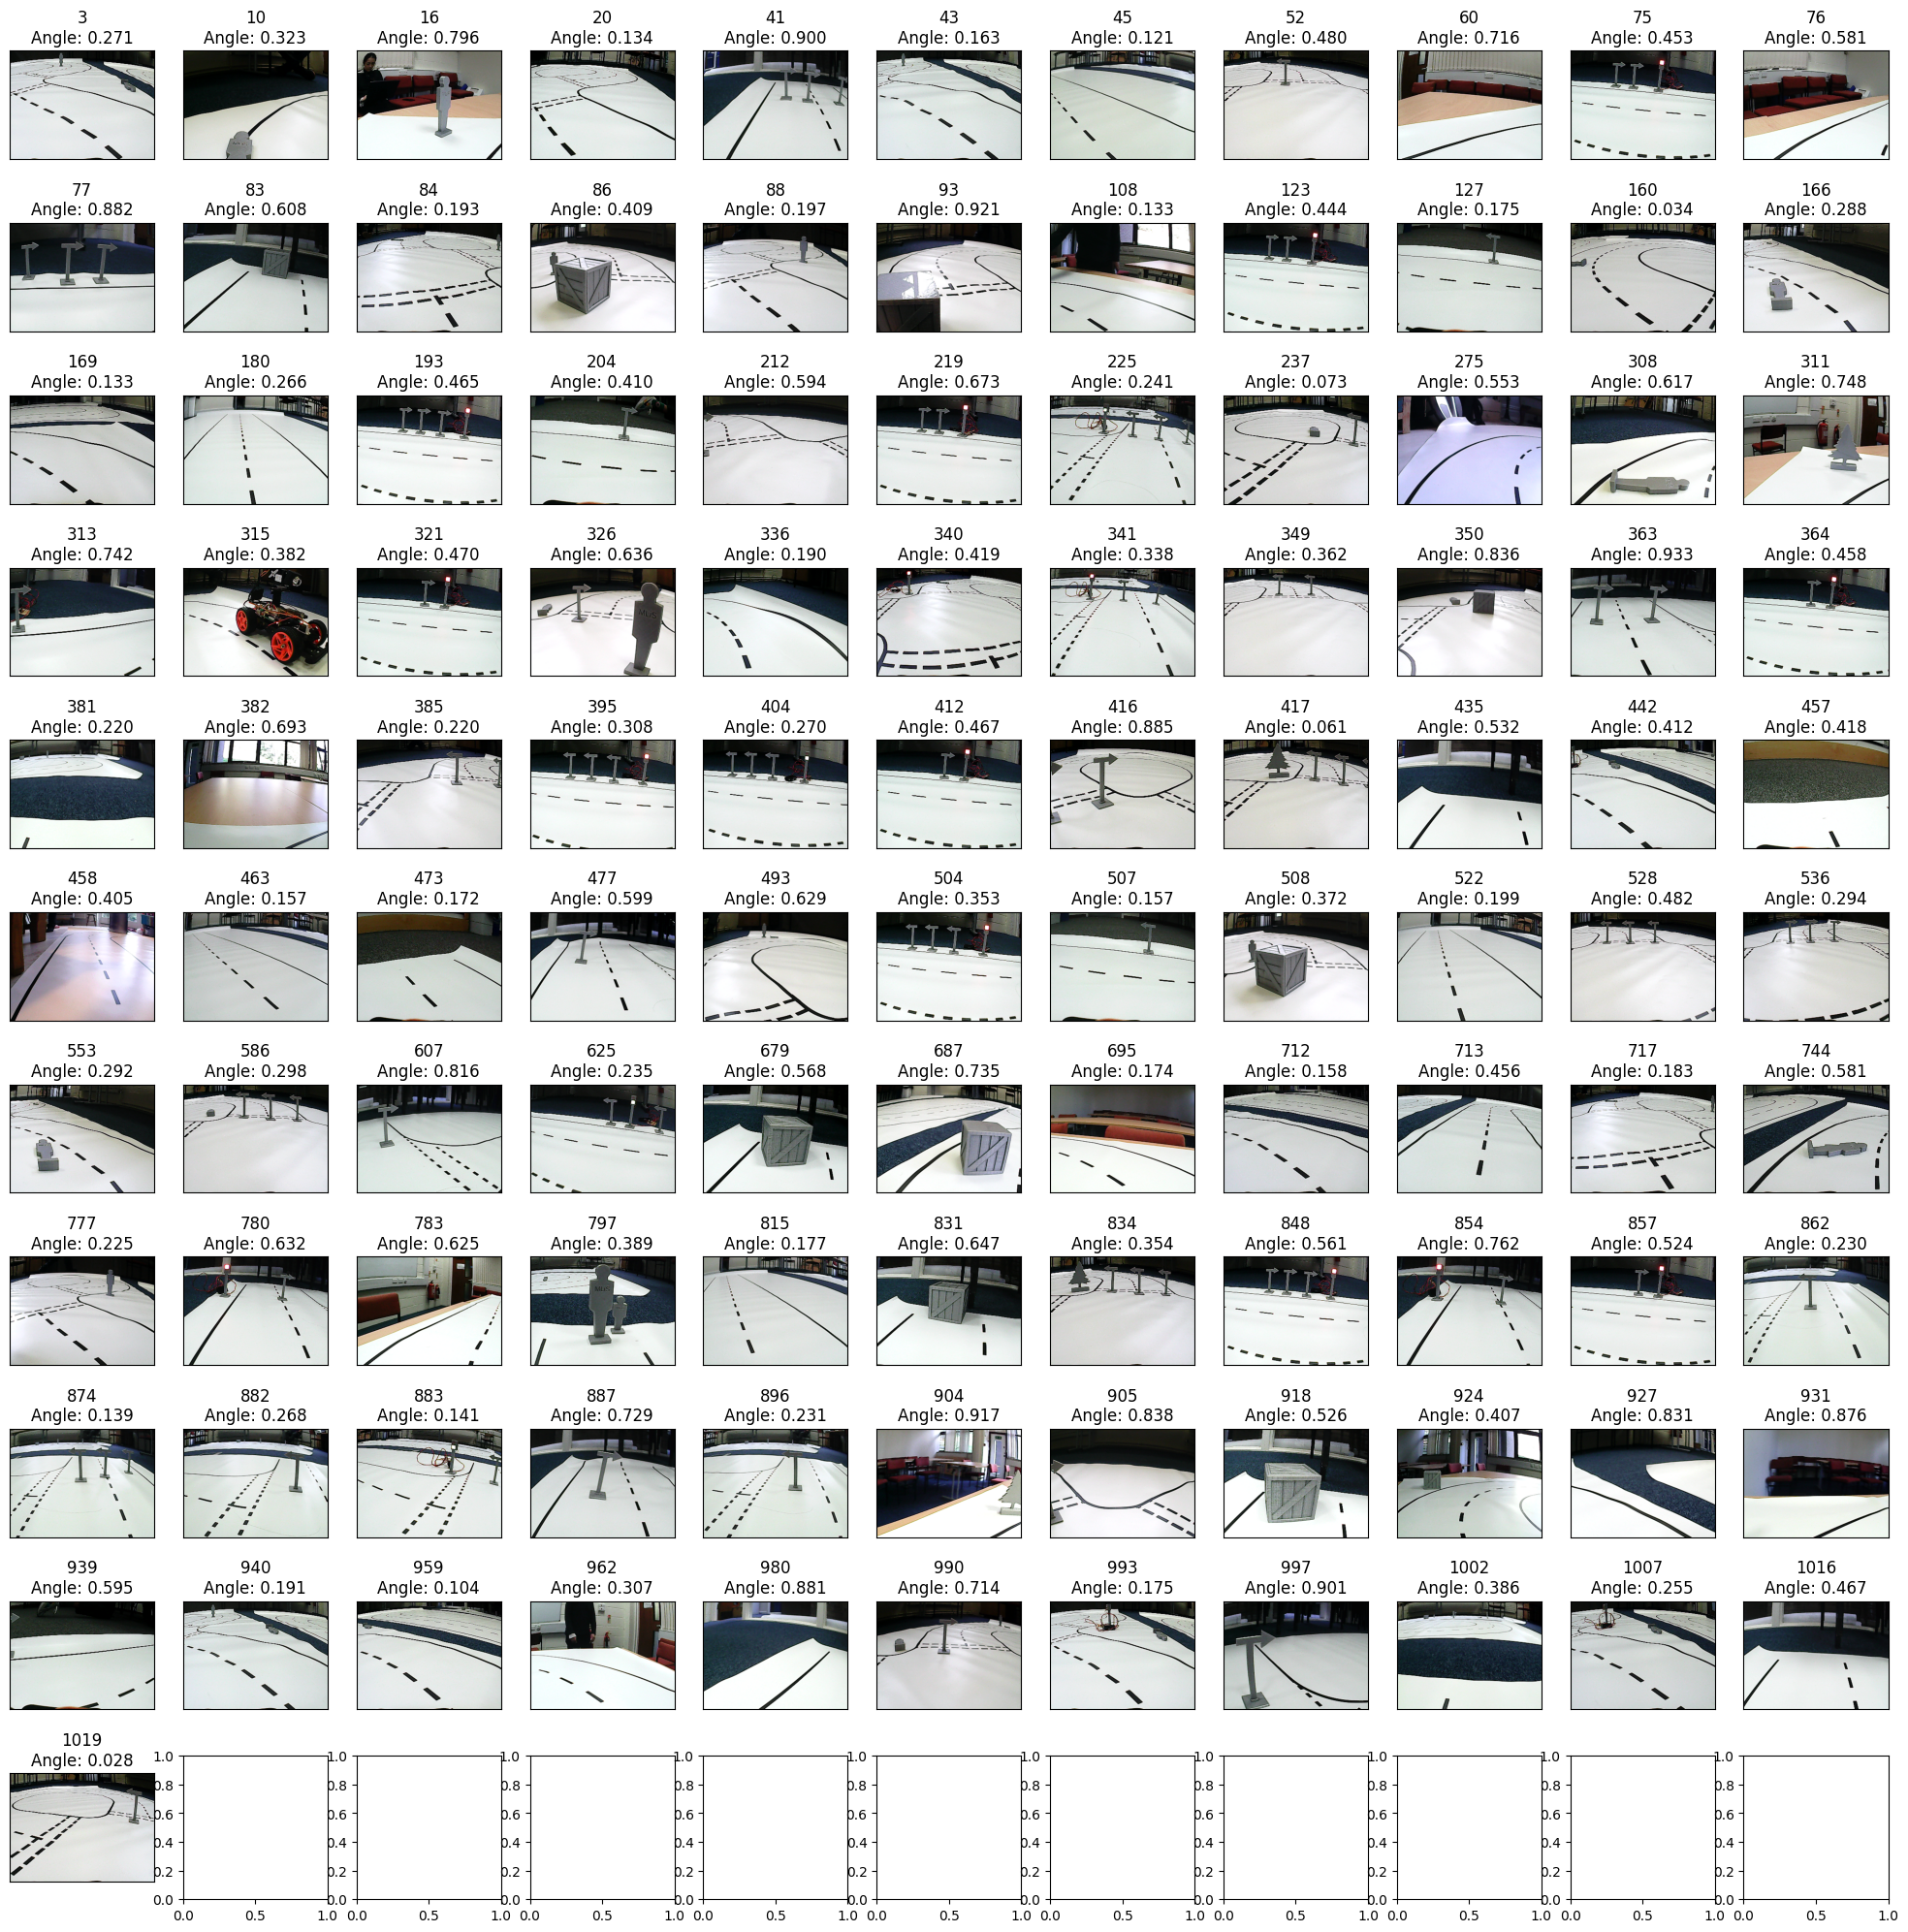

In [36]:
uncertain = df[df['std'] > 0.05].reset_index(drop=True)

fig, ax = plt.subplots(11, 11, figsize=(25, 25))
ax = ax.ravel()

for i in uncertain.index:
    image_id = (int(uncertain.loc[i]['image_id']))
    image_path = f"/mnt/c/Users/psamt/OneDrive - The University of Nottingham/_Spring/PHYS4036_Machine Learning in Science Part II/Project/Dataset/machine-learning-in-science-ii-2025/test_data/test_data/{image_id}.png"
    image = Image.open(image_path)
    ax[i].imshow(image)
    ax[i].set_title(f"{image_id}\nAngle: {uncertain.loc[i]['angle']:.3f}")
    ax[i].set_xticks([])
    ax[i].set_yticks([])

In [10]:
df = pd.DataFrame({
  'image_id': image_id_list.astype(int), 
  'angle': preds_concat_fixed_mean,
})
df

image_id     angle
0            1  0.549023
1           10  0.323376
2          100  0.661895
3         1000  0.187772
4         1001  0.183692
...        ...       ...
1015       995  0.488035
1016       996  0.739717
1017       997  0.901411
1018       998  0.686424
1019       999  0.862224

[1020 rows x 2 columns]

In [11]:
df = df.sort_values('image_id')
df

image_id     angle
0           1  0.549023
132         2  0.693741
243         3  0.270516
354         4  0.095891
465         5  0.148539
..        ...       ...
20       1016  0.466519
21       1017  0.680660
22       1018  0.363430
23       1019  0.027767
25       1020  0.030563

[1020 rows x 2 columns]

In [12]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M")  # Format: YYYYMMDD_HHMM
df.to_csv(f'prediction_angle_{timestamp}.csv', index=False)